<a href="https://colab.research.google.com/github/PyMap/AUPY/blob/master/Modulo%203/03_1_introduccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fuentes de información secundaria

## Trabajando con datos de otros ... 

![informacion](../imagenes/fuentes_de_informacion.png)

## Introducción 

En el transcurso de las clases anteriores, introducimos algunos conceptos generales sobre el manejo de datos geográficos. Trabajamos con `geopandas`, vimos lo que era un crs, geolocalizamos datos y exploramos diferentes herramientas de visualización. Ahora, nos vamos a enfocar en una forma diferente de caracterizar y entender nuestros datos: la consulta de fuentes secundarias. Este recurso es de gran utilidad, sobre todo, cuando queremos construir una descripción generalizada del entorno en el que se emplaza el fenómeno que estamos estudiando. En otras palabras, contextualizar nuestro objeto de estudio.

Por ejemplo, si quisieramos reconstruir el contexto edilicio de los frentes registrados en las partidas de conservación patrimonial (el dataset que trabajamos la clase anterior) deberíamos tener en claro cuáles son las fuentes que tenemos disponibles, su caracter o nivel de confiabilidad, con qué periodicidad se publican y, principalmente, cuál es el nivel administrativo mínimo al que abren su información. Esto último resulta de gran importancia a la hora de definir si un dato se encuentra disponible o no.

Siguiendo con el ejemplo, sabemos que para llevar adelante ese análisis deberíamos contar con información relativa a los edificios o distintos tipos de inmuebles que se encuentran en las inmediaciones de nuestras fachadas identificadas como patrimonio. Con lo cual, el dato que estamos necesitando requiere de bastante granularidad. En ese sentido, también sabemos que la información que estamos buscando refiere al estado de conservación de esos inmuebles. 

Así es que llegamos a la **propuesta para esta clase**. Este escenario nos plantea una situación que es bastante frecuente en el trabajo de un científico de datos geográficos: *la agregación y tratamiento de información a polígonos de distintos niveles*. Apoyándonos en el Censo Nacional de Población, Hogares y Viviendas (CNPHV) del Indec, trataremos de reconstruir el contexto edilicio del dataset trabajado en la clase anterior.

**Esto, lo desarrollaremos en dos partes o secciones:**

**1)** *Esquemas de clasificación*: El CNPHV nos provee información sobre una variable de interés, el estado de conservación de una vivienda a dos niveles. La calidad de sus materiales constructivos y de los servicios domiciliarios. Con esto, armaremos coropletas que nos muestren la distribución territorial de las viviendas con distintas características. 

Una vez que hagamos esto, necesitaremos entender de qué manera se clasifican estos valores. Es decr, con qué intervalos se representan nuestra variable de interés. Así, veremos cómo se construyen los esquemas de clasificación que se implementan en el método `plot` de un GeoDataFrame. Comprender esto, se vuelve de gran importancia para entender qué es lo que se busca comunicar a la hora de armar mapas coropléticos (o [coropletas](https://es.wikipedia.org/wiki/Mapa_coropl%C3%A9tico)). 

**2)** *Clases y objetos*: Asimismo, veremos cómo la construcción de nuestras propias clases puede convertirse en un recurso altamente funcional para la descripción 'a medida' de nuestro fenómeno u objeto. En nuestro caso, el territorio en el que se ubican las fachadas de edificios con certificados de conservación patrimonial. A partir de lo que se trabajó en la primera sección de la clase, utilizaremos lo allí producido para crear nuestros propios objetos  y revisar nociones como `método`, `instancia`, `clase` u `objeto`.

### Provincias, departamentos, fracciones y radios: el Censo Nacional de Población, Hogares y Viviendas.

![DIVISIONES](../imagenes/divisiones_administrativas.png)

A modo de caso testigo, para el desarrollo de la siguiente clase, seleccionaremos una de las fuentes de datos sociodemográficos más consultadas. Trabajaremos con datos del último [Censo](https://www.indec.gob.ar/indec/web/Nivel3-Tema-2-41) que realiza el Instituto Nacional de Estadísticas y Censos - INDEC. Este operativo suele repetirse aproximadamente cada diez años, por lo que los últimos resultados que se encuentran disponibles son los de 1991, 2001 y [2010](https://www.indec.gob.ar/indec/web/Nivel4-Tema-2-41-135). Como comentario breve, aclaramos que sólo los últimos dos cuentan con sus bases publicadas a nivel usuario. Ambos cuentan con el cuestionario básico accesible a nivel provincial, departamental, fracción y radio censal. 

Vale aclarar que estas no son las únicas, pero sí las [unidades geoestadísticas](https://geoservicios.indec.gov.ar/codgeo/index.php?pagina=definiciones) más comunes a la hora de trabajar el territorio nacional. Por estas, se entiende a:
<br />
...*cada una de las porciones de territorio que se utilizan para referir información estadística. Bajo esta denominación se contemplan tanto las divisiones políticas (por ej. provincias, departamentos, gobiernos locales) como aquellas unidades generadas por el Instituto a fines operativos (por ej. localidad censal, fracción censal, radio censal).*

Estas nos servirán como base cuando tengamos que definir qué nivel de granularidad le damos a nuestro análisis.

In [1]:
# importamos las librerías con las que vamos a trabajar
import pandas as pd
import matplotlib.pyplot as plt

try:
    import geopandas as gpd
except:
    !pip install geopandas
    !pip install rtree
    !apt install libspatialindex-dev

In [2]:
# Cargamos nuestro gdf de radios censales. Al igual que la clase anterior, esto lo descargamos de Buenos Aires Data.
radios = gpd.read_file('https://storage.googleapis.com/python_mdg/carto_cursos/informacion_censal_por_radio_2010.zip')

In [3]:
radios.head()

,RADIO_I,BARRIO,COMUNA,POBLACI,VIVIEND,HOGARES,HOGARES_,AREA_KM,geometry
0,1_1_1,RETIRO,1,336.0,82.0,65.0,19.0,1.798997,"POLYGON ((-58.37189 -34.59199, -58.37202 -34.5..."
1,1_12_1,SAN NICOLAS,1,341.0,365.0,116.0,25.0,0.018565,"POLYGON ((-58.38593 -34.60444, -58.38575 -34.6..."
2,1_12_10,SAN NICOLAS,1,296.0,629.0,101.0,1.0,0.044380,"POLYGON ((-58.37879 -34.60528, -58.37741 -34.6..."
3,1_12_11,SAN NICOLAS,1,528.0,375.0,136.0,7.0,0.366340,"POLYGON ((-58.36733 -34.60562, -58.36713 -34.6..."
4,1_12_2,SAN NICOLAS,1,229.0,445.0,129.0,16.0,0.018363,"POLYGON ((-58.38454 -34.60436, -58.38311 -34.6..."


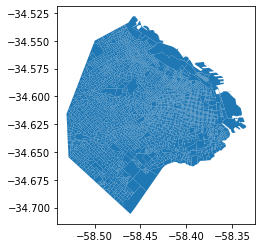

In [4]:
# los radios censales de la Ciudad de Buenos Aires...
radios.plot();

A su vez, estas unidades geoestadísticas mantienen relación entre ellas. Como mencionamos con anterioridad, una unidad de agregación mayor contiene varias de agregación menor. Por ejemplo, un departamento o Comuna (si nos situamos en la Ciudad de Buenos Aires) contiene varios radios censales, o una provincia varios departamentos. Esta relación entre distintos niveles administrativos será un atributo propio de la cartografía censal que utilizaremos como insumo a la hora de trabajar con clases. Veamoslo.

In [5]:
# cargamos el nivel de agregación mayor
comunas = gpd.read_file('https://storage.googleapis.com/python_mdg/carto_cursos/comunas.zip')

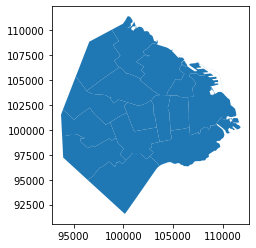

In [6]:
comunas.plot();

In [7]:
# el CRS de Buenos Aires para plotear un mapa más prolijo
import pyproj

In [8]:
from pyproj import CRS

In [9]:
wkt = """PROJCS["GKBA",
        GEOGCS["International 1909 (Hayford)",
            DATUM["CAI",
                SPHEROID["intl",6378388,297]],
            PRIMEM["Greenwich",0],
            UNIT["degree",0.0174532925199433]],
        PROJECTION["Transverse_Mercator"],
        PARAMETER["latitude_of_origin",-34.6297166],
        PARAMETER["central_meridian",-58.4627],
        PARAMETER["scale_factor",0.999998],
        PARAMETER["false_easting",100000],
        PARAMETER["false_northing",100000],
        UNIT["Meter",1]]"""

In [10]:
wkt_bsas = pyproj.CRS(wkt)

In [11]:
%matplotlib inline

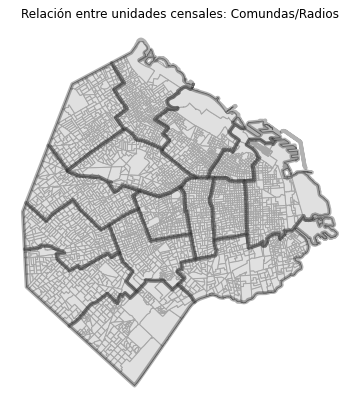

In [12]:
# ... y graficamos la relación entre ambos niveles
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(1,1,1)

radios.to_crs(wkt_bsas).plot(ax=ax, color='lightgrey', edgecolor= 'grey', linewidth = 1)
comunas.to_crs(wkt_bsas).plot(ax=ax,color='white', edgecolor= 'black', linewidth = 4, alpha = 0.3)

ax.set_axis_off()
ax.set_title('Relación entre unidades censales: Comundas/Radios');

Ahora sí, comencemos con la primera parte de esta clase...